# Project Title
### Data Engineering Capstone Project

#### Project Summary
This project emulates a real case scenario where an automated ETL process is required to explore and analyse data from immigration, airports and demographics in US to have a better understanding on this topic.
The idea behind this project is to generate an individualized social plan for each city to integrate and help the newcomers. The main goal is to generate three types of solutions:
* Plan for students integration
* Plan for families that came for business  
* Plan for Tourists 

For each city it would be studied the type of immigration that exist, and try to adequate the best plan according to the city needs and offer.

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [2]:
# Do all imports and installs here
import pandas as pd
import os


## Step 1: Scope the Project and Gather Data

### Scope 
To be a newcomer in a new country is very dfficut. The culture, friends, family, or even loneliness can be dangerous factors to have a bad experience in a new city. To help on the integration of these newcomers I want to do a permanent dashboard report to show the data from immigration together with supplementary data that can allow us to design individualized action plans for Students, Business and Travelers for the different cities in USA. 

The end solution would be a dashboard with the information of each registered city together with the immigration flux that they recieve and the typer of newcomers that they are recieving. Then I would merge this information with the specifications of the city to see what is already offering and how we could organize a better plan for a city in particular. Finaly, It would be interesting to have the option to add the information of the airports and the arrivals to see if it is a good place to let people know about the new plans that the city has prepared forr them. 

The Data pipeline that I have used to carry out this project is the following:

1) Three different data sources that have been explored with Apache Spark to easily manage such quantity of data. The idea was to explore the DB columns and the quality issues that could have. 

2) Then from all the different sources we generate csv files to easily load them in an s3 Amazon resource. This s3 is acting as a Data Lake where all the raw data is loaded. in the future more data could be included as satisfaction polls, cultural offer ... 

3) The data has been extracted from the s3 to copy it in a Readshift Amazon resource, acting as a data Warehouse. 

4) The data present in the Redshift is Transformed using a snowflake relational structure to easily generate dashboards from it. 




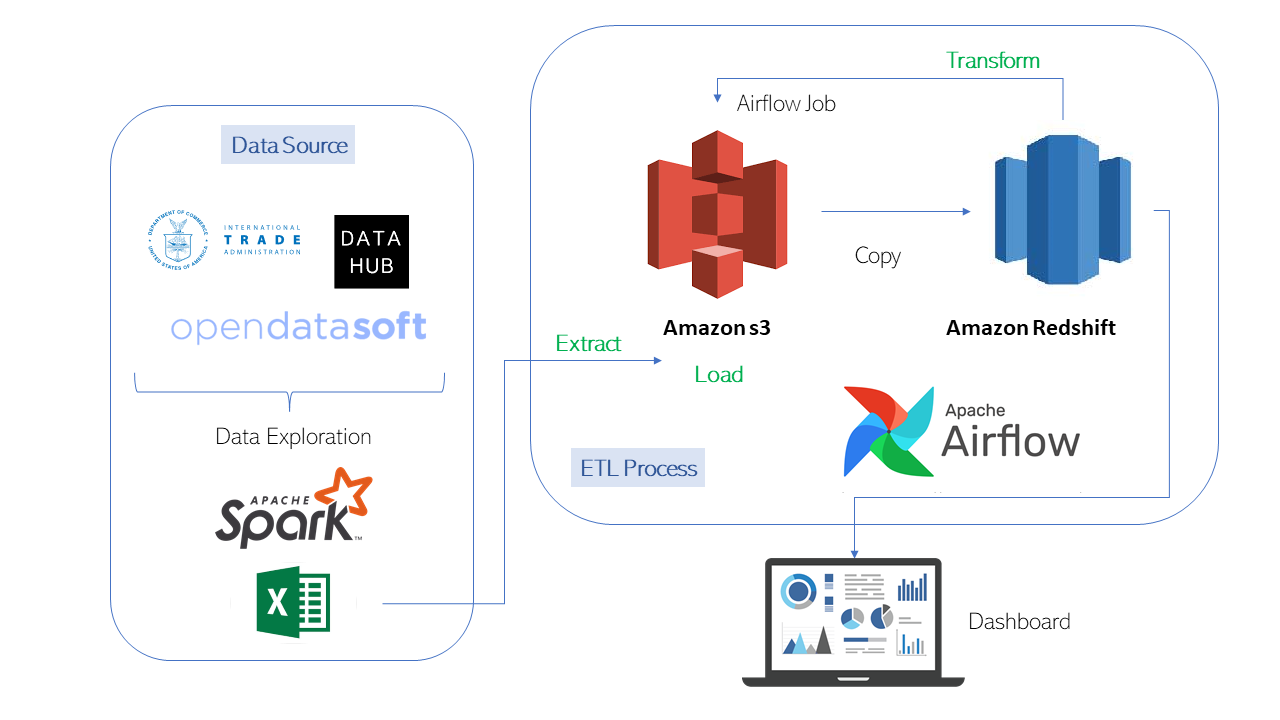

In [2]:
from IPython.display import Image
Image(filename='DataPipeline.PNG') 

### Describe and Gather Data 

* I94 Immigration Data: This data comes from the US National Tourism and Trade Office. A data dictionary is included in the workspace. This is where the data comes from https://www.trade.gov/national-travel-and-tourism-office. 
* U.S. City Demographic Data: This data comes from OpenSoft. You can read more about it here https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data
* Airport Code Table: This is a simple table of airport codes and corresponding cities. It comes from here https://datahub.io/core/airport-codes#data

#### 1. Data from Immigration - USA

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.functions import countDistinct

spark = SparkSession.builder.\
config("spark.jars.repositories", "https://repos.spark-packages.org/").\
config("spark.jars.packages", "saurfang:spark-sas7bdat:2.0.0-s_2.11").\
enableHiveSupport().getOrCreate()

df_spark = spark.read.format('com.github.saurfang.sas.spark').load('../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat')
#df_spark.write.parquet("sas_data")
df_spark=spark.read.parquet("sas_data")
df_spark.printSchema()
print('Total number of entries:',df_spark.count())
df_spark.limit(5).toPandas()

root
 |-- cicid: double (nullable = true)
 |-- i94yr: double (nullable = true)
 |-- i94mon: double (nullable = true)
 |-- i94cit: double (nullable = true)
 |-- i94res: double (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: double (nullable = true)
 |-- i94mode: double (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: double (nullable = true)
 |-- i94bir: double (nullable = true)
 |-- i94visa: double (nullable = true)
 |-- count: double (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- occup: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- entdepu: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: double (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- insnum: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: double (nullable = 

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,5748517.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,CA,20582.0,...,None,M,1976.0,10292016,F,None,QF,9.495387e+10,00011,B1
1,5748518.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,NV,20591.0,...,None,M,1984.0,10292016,F,None,VA,9.495562e+10,00007,B1
2,5748519.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,WA,20582.0,...,None,M,1987.0,10292016,M,None,DL,9.495641e+10,00040,B1
3,5748520.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,WA,20588.0,...,None,M,1987.0,10292016,F,None,DL,9.495645e+10,00040,B1
4,5748521.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,WA,20588.0,...,None,M,1988.0,10292016,M,None,DL,9.495639e+10,00040,B1


#### 2. Data from Demographic Department - USA

In [119]:
script_dir = os.getcwd()
city_file = 'us-cities-demographics.csv'
city_path = os.path.join(script_dir, city_file)
city_df = spark.read.csv(city_path, sep=';', header= True )
city_df.printSchema()
print('Total number of entries:',city_df.count())
city_df.limit(5).toPandas()


root
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Median Age: string (nullable = true)
 |-- Male Population: string (nullable = true)
 |-- Female Population: string (nullable = true)
 |-- Total Population: string (nullable = true)
 |-- Number of Veterans: string (nullable = true)
 |-- Foreign-born: string (nullable = true)
 |-- Average Household Size: string (nullable = true)
 |-- State Code: string (nullable = true)
 |-- Race: string (nullable = true)
 |-- Count: string (nullable = true)

Total number of entries: 2891


,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601,41862,82463,1562,30908,2.6,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129,49500,93629,4147,32935,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040,46799,84839,4819,8229,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127,87105,175232,5821,33878,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040,143873,281913,5829,86253,2.73,NJ,White,76402


#### 3. Data from Airports - USA

In [127]:
air_file = 'airport-codes_csv.csv'
air_path = os.path.join(script_dir, air_file)
air_df = spark.read.csv(air_path, header= True )
air_df.printSchema()
print('Total number of entries:',air_df.count())
air_df.limit(5).toPandas()


root
 |-- ident: string (nullable = true)
 |-- type: string (nullable = true)
 |-- name: string (nullable = true)
 |-- elevation_ft: string (nullable = true)
 |-- continent: string (nullable = true)
 |-- iso_country: string (nullable = true)
 |-- iso_region: string (nullable = true)
 |-- municipality: string (nullable = true)
 |-- gps_code: string (nullable = true)
 |-- iata_code: string (nullable = true)
 |-- local_code: string (nullable = true)
 |-- coordinates: string (nullable = true)

Total number of entries: 55075


,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11,NA,US,US-PA,Bensalem,00A,None,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435,NA,US,US-KS,Leoti,00AA,None,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450,NA,US,US-AK,Anchor Point,00AK,None,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820,NA,US,US-AL,Harvest,00AL,None,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237,NA,US,US-AR,Newport,None,None,None,"-91.254898, 35.6087"


### Step 2: Explore and Assess the Data
#### Explore the Data 
In this section we will explore and identify data quality issues, like missing values or duplicate data in order to corroborate that the idea of data modelling that I will present is plausible and will gives us usefull information. 
##### 1. Discard fields without information
These are the fields that I would like to add in my tables. However, it is needed to assess all the fields to see if all of them are giving us information.


In [129]:
print('IMMIGRATION TABLE')
print('Number of Null values in "cicid" column:', df_spark.filter(df_spark.cicid.isNull()).count())
print('Number of Null values in "gender" column:', df_spark.filter(df_spark.gender.isNull()).count())
print('Number of Null values in "biryear" column:', df_spark.filter(df_spark.biryear.isNull()).count())
print('Number of Null values in "i94cit" column:', df_spark.filter(df_spark.i94cit.isNull()).count())
print('Number of Null values in "i94addr" column:', df_spark.filter(df_spark.i94addr.isNull()).count())
print('Number of Null values in "fltno" column:', df_spark.filter(df_spark.fltno.isNull()).count())
print('Number of Null values in "airline" column:', df_spark.filter(df_spark.airline.isNull()).count())
print('Number of Null values in "i94port" column:', df_spark.filter(df_spark.i94port.isNull()).count())
print('Number of Null values in "arrdate" column:', df_spark.filter(df_spark.arrdate.isNull()).count())
print('Number of Null values in "i94mode" column:', df_spark.filter(df_spark.i94mode.isNull()).count())
print('Number of Null values in "admnum" column:', df_spark.filter(df_spark.admnum.isNull()).count())
print('Number of Null values in "visapost" column:', df_spark.filter(df_spark.visapost.isNull()).count())
print('Number of Null values in "visatype" column:', df_spark.filter(df_spark.visatype.isNull()).count())
print('Number of Null values in "entdepa" column:', df_spark.filter(df_spark.entdepa.isNull()).count())
print('Number of Null values in "entdepd" column:', df_spark.filter(df_spark.entdepd.isNull()).count())
print('Number of Null values in "entdepu" column:', df_spark.filter(df_spark.entdepu.isNull()).count())

print('Total number of entries:',df_spark.count())

print('CITIES TABLE')
print('Number of Null values in "City" column:', city_df.filter(city_df.City.isNull()).count())
print('Number of Null values in "Median Age" column:', city_df.filter(col("Median Age").isNull()).count())
print('Number of Null values in "Male Population" column:', city_df.filter(col("Male Population").isNull()).count())
print('Number of Null values in "Female Population" column:', city_df.filter(col("Female Population").isNull()).count())
print('Number of Null values in "Total Population" column:', city_df.filter(col("Total Population").isNull()).count())
print('Number of Null values in "Foreign-born" column:', city_df.filter(col("Foreign-born").isNull()).count())

print('Total number of entries:',city_df.count())

print('AIRPORTS TABLE')
print('Number of Null values in "ident" column:', air_df.filter(air_df.ident.isNull()).count())
print('Number of Null values in "type" column:', air_df.filter(air_df.type.isNull()).count())
print('Number of Null values in "name" column:', air_df.filter(air_df.name.isNull()).count())
print('Number of Null values in "municipality" column:', air_df.filter(air_df.municipality.isNull()).count())
print('Number of Null values in "coordinates" column:', air_df.filter(air_df.coordinates.isNull()).count())


print('Total number of entries:',air_df.count())


IMMIGRATION TABLE
Number of Null values in "cicid" column: 0
Number of Null values in "gender" column: 414269
Number of Null values in "biryear" column: 802
Number of Null values in "i94cit" column: 0
Number of Null values in "i94addr" column: 152592
Number of Null values in "fltno" column: 19549
Number of Null values in "airline" column: 83627
Number of Null values in "i94port" column: 0
Number of Null values in "arrdate" column: 0
Number of Null values in "i94mode" column: 239
Number of Null values in "admnum" column: 0
Number of Null values in "visapost" column: 1881250
Number of Null values in "visatype" column: 0
Number of Null values in "entdepa" column: 238
Number of Null values in "entdepd" column: 138429
Number of Null values in "entdepu" column: 3095921
Total number of entries: 3096313
CITIES TABLE
Number of Null values in "City" column: 0
Number of Null values in "Median Age" column: 0
Number of Null values in "Male Population" column: 3
Number of Null values in "Female Popu

##### 2. Discard possible IDs that are not unique
 In order to select the best Primary keys for our data model, we need to know the proportional part of distinc values that are in each field of interest.  

In [143]:
print('IMMIGRATION TABLE')
print("Distinct Count for column 'cicid': " + str(df_spark.select('cicid').distinct().count()))
print("Distinct Count for column 'admnum':" + str(df_spark.select('admnum').distinct().count()))
print("Distinct Count for column 'fltno':" + str(df_spark.select('fltno').distinct().count()))

print('CITIES TABLE')
print("Distinct Count for column 'City': " + str(city_df.select('City').distinct().count()))

print('AIRPORTS TABLE')
print("Distinct Count for column 'ident': " + str(air_df.select('ident').distinct().count()))

IMMIGRATION TABLE
Distinct Count for column 'cicid': 3096313
Distinct Count for column 'admnum':3075579
Distinct Count for column 'fltno':7153
CITIES TABLE
Distinct Count for column 'City': 567
AIRPORTS TABLE
Distinct Count for column 'ident': 55075


#### Cleaning Steps
Since we want to produce excel files using Apache Spark, here is the moment to change some column names to make it easy the extraction and the transformation. 


In [157]:
df2 = city_df.withColumnRenamed("Median Age","Median_Age") \
    .withColumnRenamed("Male Population","Male_Population") \
    .withColumnRenamed("Female Population","Female_Population") \
    .withColumnRenamed("Total Population","Total_Population") \
    .withColumnRenamed("Number of Veterans","Number_of_Veterans") \
    .withColumnRenamed("Average Household Size","Average_Household_Size") \
    .withColumnRenamed("State Code","State_Code") \

df2.limit(5).toPandas()
file_name= 'NEWus-cities-demographics.csv'
NEWcity_path = os.path.join(script_dir, file_name)
df2.toPandas().to_csv(NEWcity_path, index = False, header=True)


### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
The Conceptual Data model I used is a relational model following a snowflake structure.  The snowflake schema is represented by centralized fact tables which are connected to multiple dimensions. "Snowflaking" is a method of normalizing the dimension tables in a star schema. The principle behind snowflaking is normalization of the dimension tables by removing low cardinality attributes and forming separate tables.
STRUCTURE:
* ENTRIES TABLE: It is the fact table. It has as columns identifyers and two values used for summary statistics on demographics and immigration.
* NEWCOMERS TABLE: It is a L1 dimension table. It gives us personal information about the newcomer that have just arrived. In addition two tables are linked to this.
* VISA TABLE: It is a L2 dimension table that gives us a really detailed information about the visa that this newcomer has adqured and the leagl characteristics linked to it.
* FLIGHTS: It is a L2 dimansion table that gives us information about the flight in which a part of the newcomers have arrived. This information will allow us to stablish a link between the newcommer and the airport information. 
* CITIES TABLE: It is a L1 dimension table. It gathers the information about some important characteristics of the cities in US. This table will allow us to do individualized action plans for the different cities. 
* AIRPORTS TABLE: It is a L1 dimesion table. It gathers the basic information about all the airports in US. This information will allow us to allocate the best spot to make the plan known for the newcomers. 

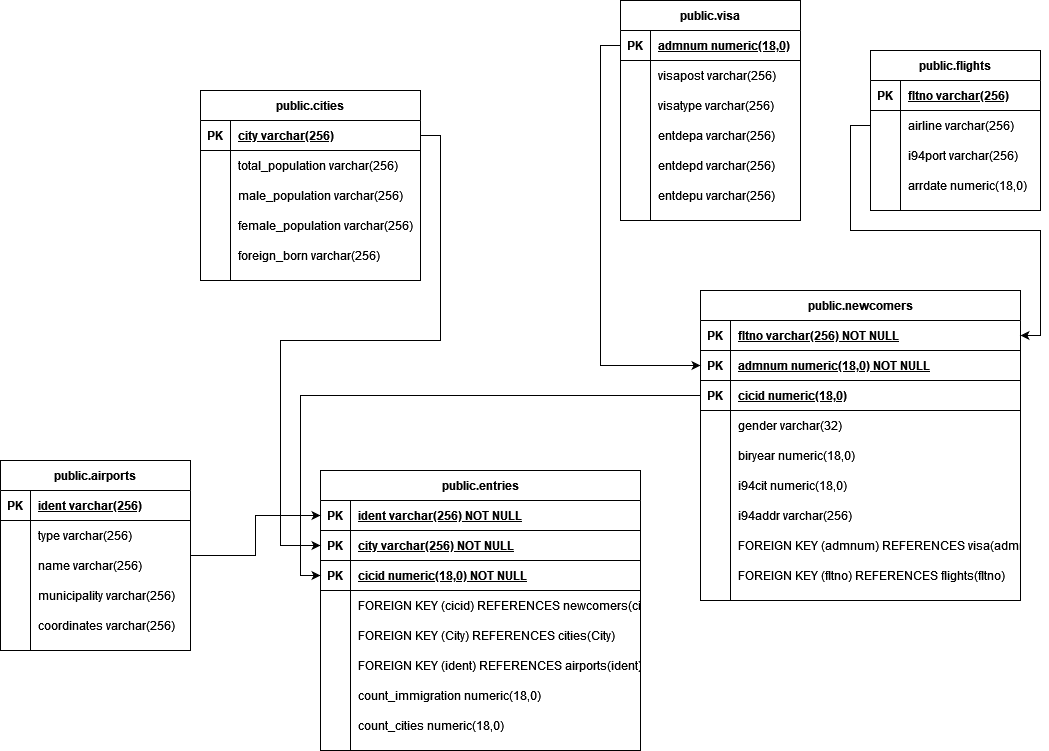

In [4]:
from IPython.display import Image
Image(filename='EMRdiagram1.png') 

#### 3.2 Mapping Out Data Pipelines
This project have been carried out wit Apache Airflow to automate the Data pipeline. The DAG consists of 7 different steps:

    1) Begin_execution: Dummy task to start the process
    
    2) Stage_table: In this stept the three different tables from s3 are copied to our Redshift.
    
    3) check_table_data: In order to assure that all the data has been copied correctly, we will execute a check to see if there are the expected number of rows in our staging_table 
    tables.
    
    4) Load_entries_fact_table: In this task we perform our first transformation to generate our fact table.
    
    5) Load_table_dim_table: In these tasks we generate all the L1 and L2 dimension tables.
    
    6) Run data_quality_checks: In this check we want to know if some ID is a null value. 
    
    7) stop_execution: Dummy task to stop the process. 

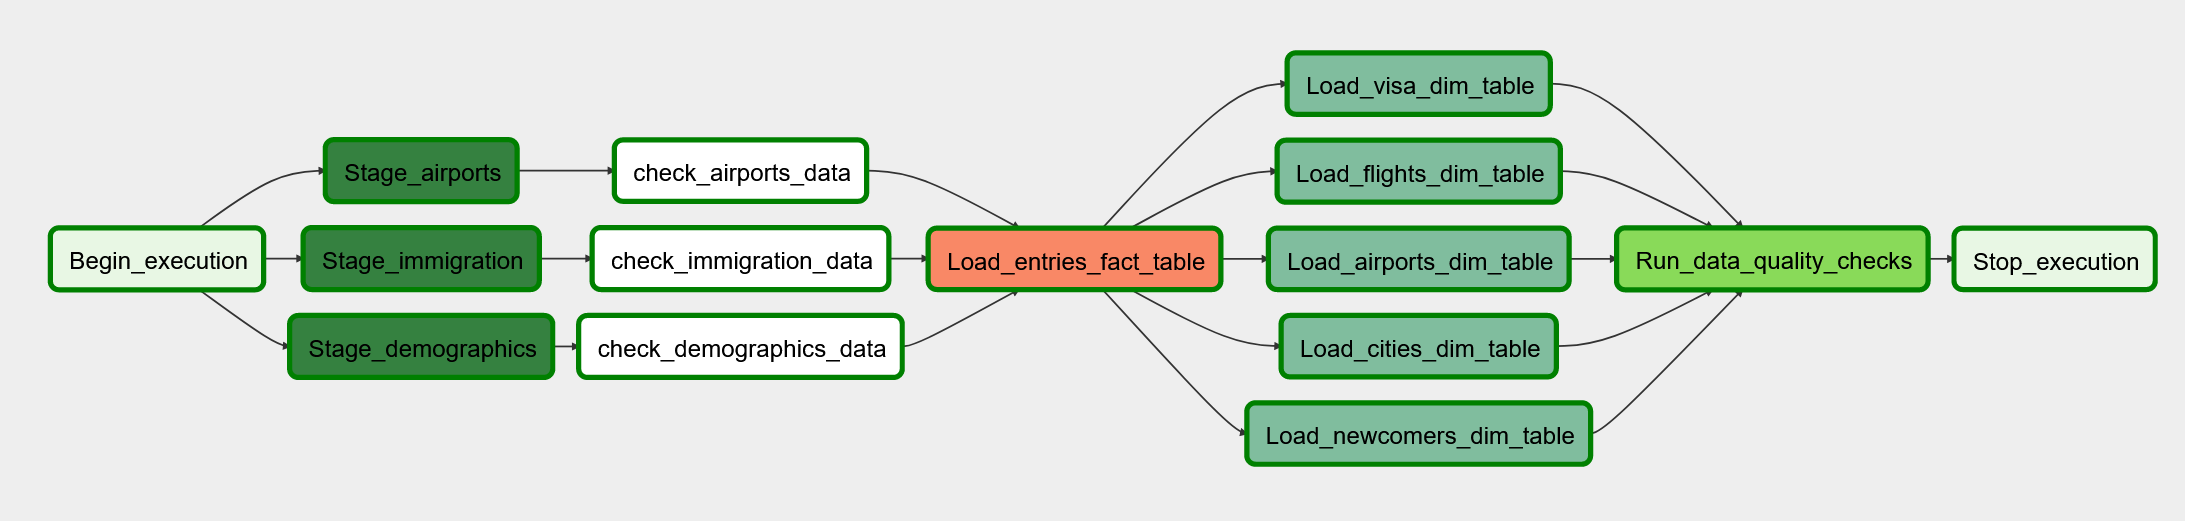

In [5]:
from IPython.display import Image
Image(filename='DAGdiagram.PNG') 

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

The data pipeline have been created by using Apache Airflow. All the needed scripts to run the designed data pipeline are uploaded in a folder called Airflow. 

Here is the designed DAG:

    start_operator >> stage_immigration_to_redshift
    start_operator >> stage_demographics_to_redshift
    start_operator >> stage_airports_to_redshift

    stage_immigration_to_redshift >> check_immigration
    stage_demographics_to_redshift >> check_demographics
    stage_airports_to_redshift >> check_airports

    check_immigration >> load_entries_table
    check_demographics >> load_entries_table
    check_airports >> load_entries_table

    load_entries_table >> load_newcomers_dimension_table
    load_entries_table >> load_visa_dimension_table
    load_entries_table >> load_flights_dimension_table
    load_entries_table >> load_cities_dimension_table
    load_entries_table >> load_airports_dimension_table

    load_newcomers_dimension_table >> run_quality_checks
    load_visa_dimension_table >> run_quality_checks
    load_flights_dimension_table >> run_quality_checks
    load_cities_dimension_table >> run_quality_checks
    load_airports_dimension_table >> run_quality_checks

    run_quality_checks >> end_operator

#### 4.2 Data Quality Checks
For tihs project two different Data Quality Checks have been designed. I have placed them in different points of the data pipeline to make it easy the debug in case some errors occur during the ETL process. 

##### 1) HasRowsOperator =  check_'table' task
Goal: To check if the staged tables have been copied with all the information from the csvs from the s3.

Position: This check has been allocated after the 'Extract' step.

##### 2) DataQualityOperator =  Run_data_quality_checks task
Goal: To check if all the Ids from the different tables are not null values, therefore we can have extract useful information from them. 

In addition we want to check that all the rows from the corresponding Primary keys are distinct

Position: This check has been allocated after the 'Transform' step. If some problems are detected here, we can go up to the previous check to see if the problem was from the 'Extract step or from the 'Transform'.


#### 4.3 Data dictionary 
I have created a data dictionary for my data model. For each field, I provide a brief description of what the data is and where it came from. This document can be found with the name "DataDictionary.PDF" in the same folder of the project. 

In this section we can also see some query tests that I have performed to corroborate that the ETL process has succeed. 

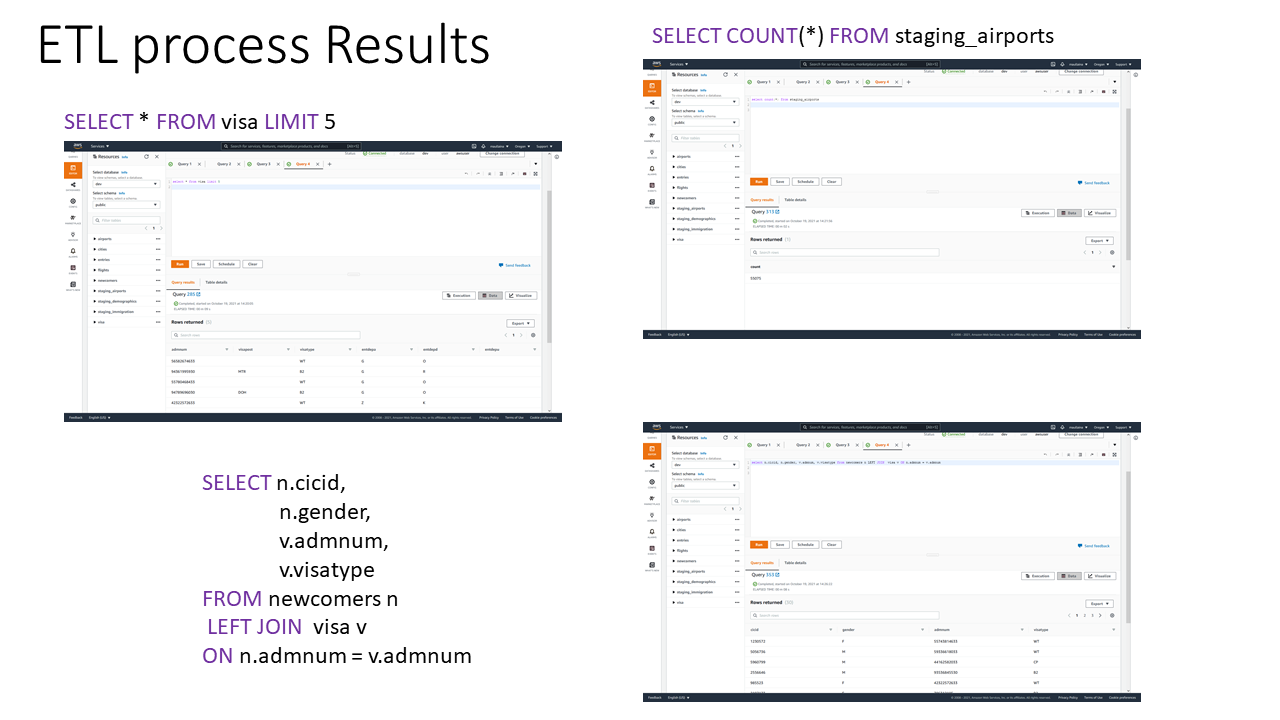

In [1]:
from IPython.display import Image
Image(filename='Results.PNG') 

#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.
* Propose how often the data should be updated and why.
* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
 * The database needed to be accessed by 100+ people.

#### Tools and Technologies
1) Apache spark: It is an open-source, distributed processing system used for big data workloads. It utilizes in-memory caching, and optimized query execution for fast analytic queries against data of any size. It allow me to explore the data in an easy and fast way. 

2) s3 Amazon Resourse: s3 is an object storage service that offers industry-leading scalability, data availability, security, and performance. You can use Amazon S3 to store and retrieve any amount of data at any time, from anywhere.

3) Redshift Amazon Resource: It is a fast, fully managed data warehouse that makes it simple and cost-effective to analyze data using standard SQL with existing Business Intelligence (BI) tools. Here we transform the data to obtain our clean data modell prepared to create dasboards and analisys. 

4) Apache Airflow: It is an open-source tool to programmatically author, schedule, and monitor workflows. 

#### Data Update Frequency
1) Tables created from immigration data set should be updated monthly since the raw data set is built up monthly.

2) Tables created from demography data set could be updated annually since demography data collection takes time and high frequent demography might take high cost but generate wrong conclusion.

3) All tables should be update in an append-only mode.

#### Future Design Considerations
* The data was increased by 100x
Both s3 and Redshift can scale-up with more capacity to absorve 100x data increase. However, I would suggest to create an Amazon EMR with a previus ingestion of the data using Apache Spark. 

* The data populates a dashboard that must be updated on a daily basis by 7am every day.
This should not be a problem since I am using Airflow already. With Airflow you can automate data pipelines in a very robust way and in a high level of customization

* The database needed to be accessed by 100+ people.

Redshift can make 500 concurrent connections to the cluster but it says maximum 15 queries can be run at the same time in a cluster. That is why I would suggest to change the connection configuration through the AWS console:

> ALTER DATABASE db_name CONNECTION LIMIT 500;      
> ALTER DATABASE db_name CONNECTION LIMIT UNLIMITED;
